In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose,STL
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Looking at Daily Data

In [ ]:
tickers = ['GC=F']

price = yf.download(tickers, start='2018-01-01',end='2025-07-06',multi_level_index=False)

/tmp/ipython-input-3-959381519.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download(tickers, start='2018-01-01',end='2025-07-06',multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


In [ ]:
price

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,1313.699951,1317.599976,1302.300049,1302.300049,68
2018-01-03,1316.199951,1320.099976,1312.099976,1320.000000,42
2018-01-04,1319.400024,1322.000000,1319.400024,1319.400024,2
2018-01-05,1320.300049,1320.300049,1320.300049,1320.300049,1
2018-01-08,1318.599976,1319.900024,1314.599976,1319.900024,41
...,...,...,...,...,...
2025-06-30,3294.399902,3306.899902,3262.000000,3265.899902,1242
2025-07-01,3336.699951,3354.100098,3310.100098,3310.100098,371
2025-07-02,3348.000000,3357.500000,3329.000000,3329.000000,39


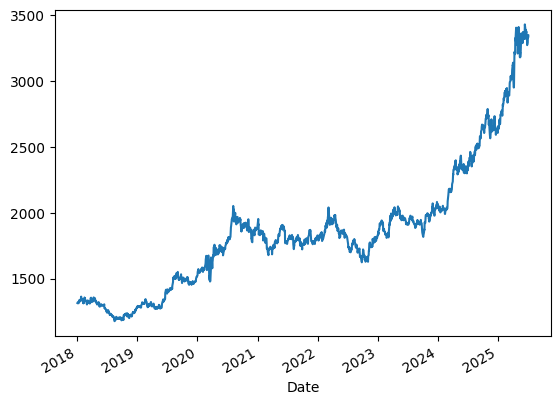

In [ ]:
price["Close"].plot();

In [ ]:
close=price["Close"]
ret=pd.DataFrame()
ret['Returns']=close.pct_change()
ret["Volume"]=price["Volume"]
ret.dropna(inplace=True)
ret

,Returns,Volume
Date,,
2018-01-03,0.001903,42
2018-01-04,0.002431,2
2018-01-05,0.000682,1
2018-01-08,-0.001288,41
2018-01-09,-0.005233,16
...,...,...
2025-06-30,0.006323,1242
2025-07-01,0.012840,371
2025-07-02,0.003387,39


In [ ]:
ret.index=pd.to_datetime(ret.index)

In [ ]:
print(type(ret.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


<Axes: xlabel='Date'>

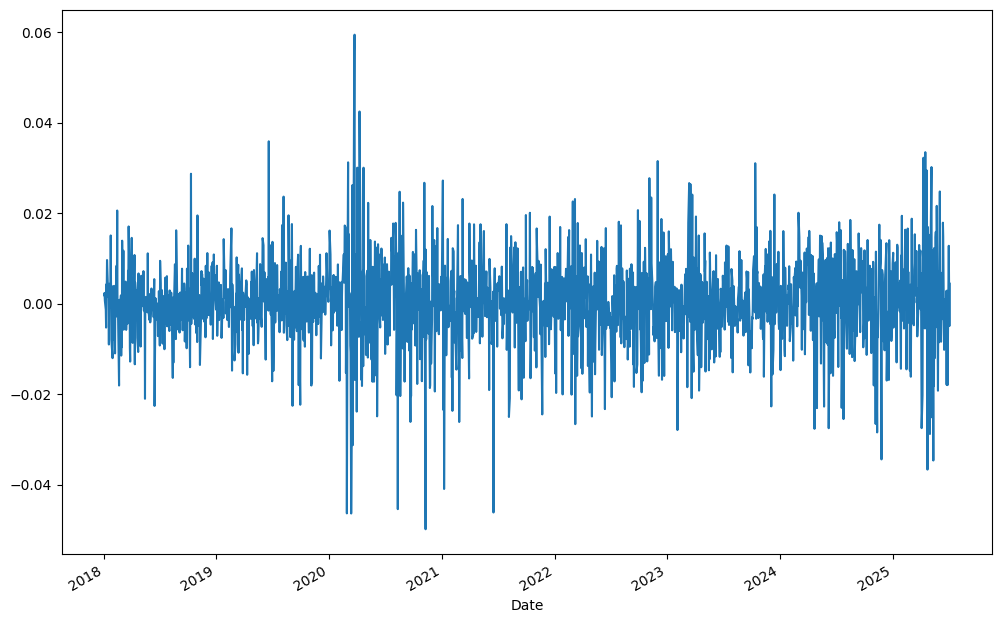

In [ ]:
ret["Returns"].plot(figsize=(12,8))

In [ ]:
from statsmodels.tsa.stattools import adfuller  ## to check stationarity of returns since it is differenced once

adf,p_val,_,_,cv,_=adfuller(ret["Returns"])
# print(f"adf:{adf}\n p_val:{p_val:0.5f},\n cv:{cv}")
if p_val>0.05:
  print("Not Sationary")
else:
  print("Stationary")

Stationary


In [ ]:
ret['Year'] = ret.index.year
ret['Month'] = ret.index.month
ret['DayOfWeek'] = ret.index.dayofweek
ret

,Returns,Volume,Year,Month,DayOfWeek
Date,,,,,
2018-01-03,0.001903,42,2018,1,2
2018-01-04,0.002431,2,2018,1,3
2018-01-05,0.000682,1,2018,1,4
2018-01-08,-0.001288,41,2018,1,0
2018-01-09,-0.005233,16,2018,1,1
...,...,...,...,...,...
2025-06-30,0.006323,1242,2025,6,0
2025-07-01,0.012840,371,2025,7,1
2025-07-02,0.003387,39,2025,7,2


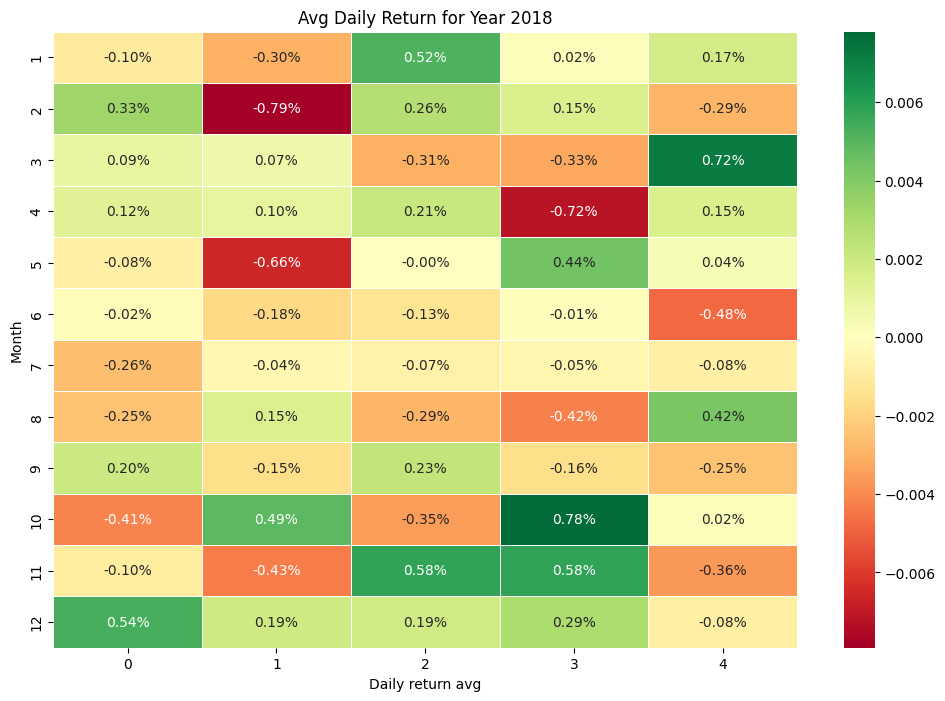

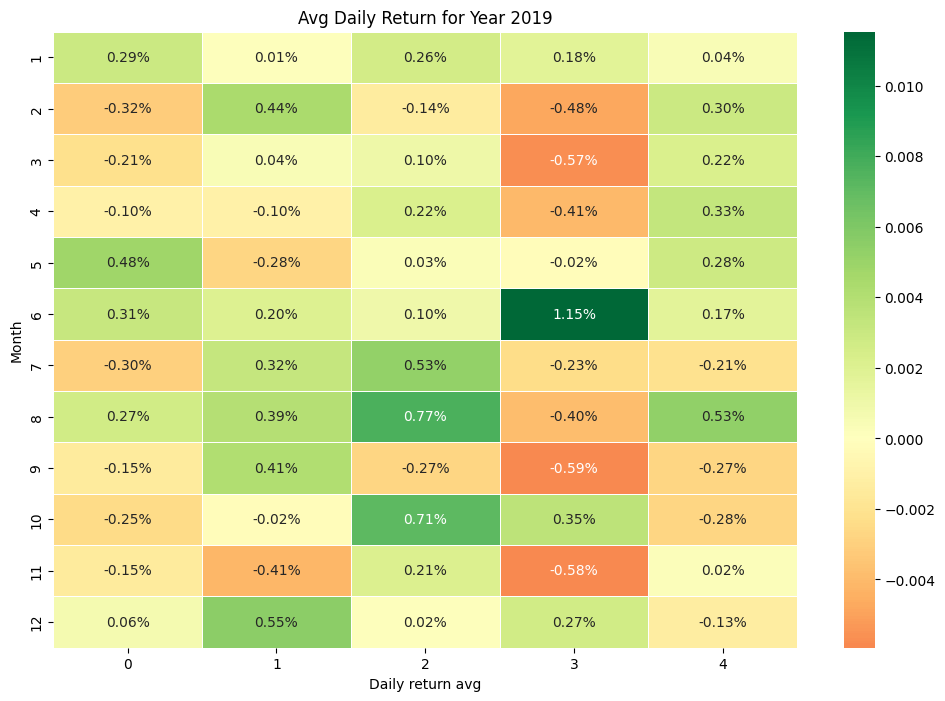

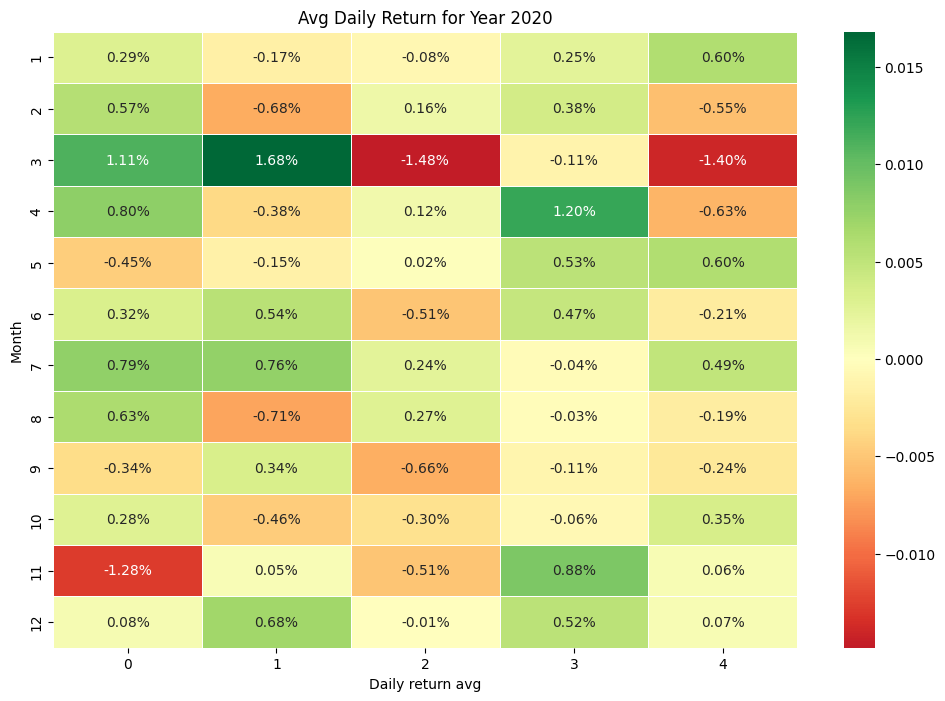

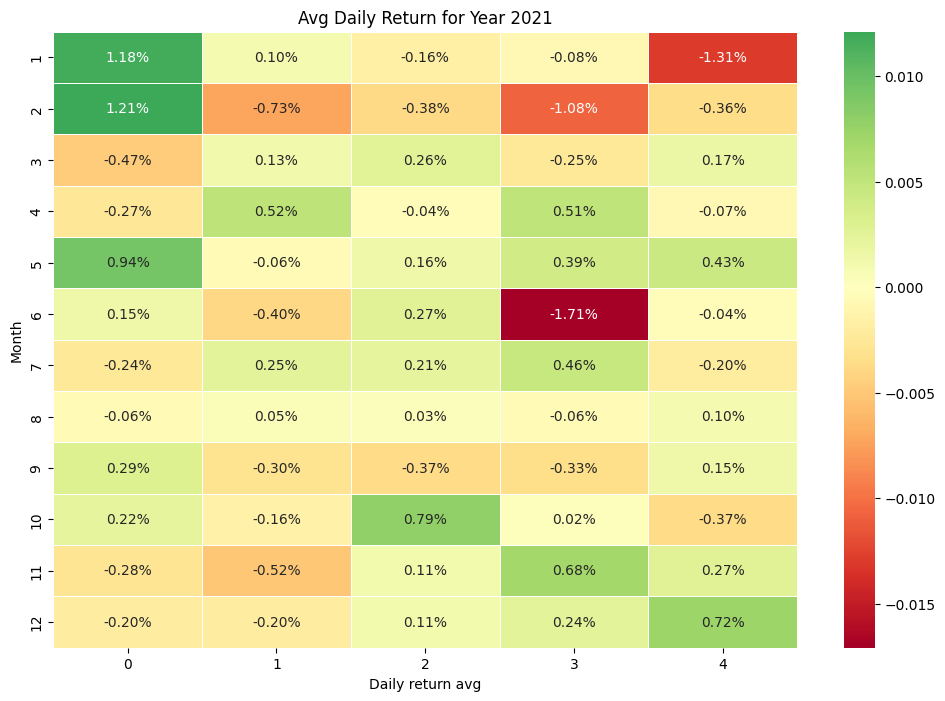

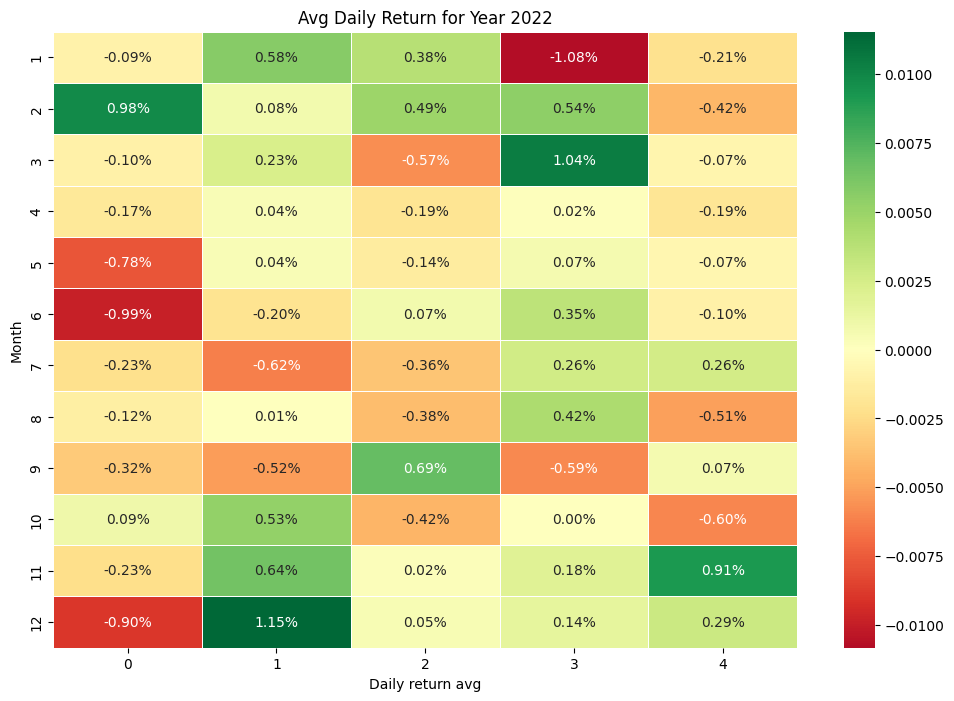

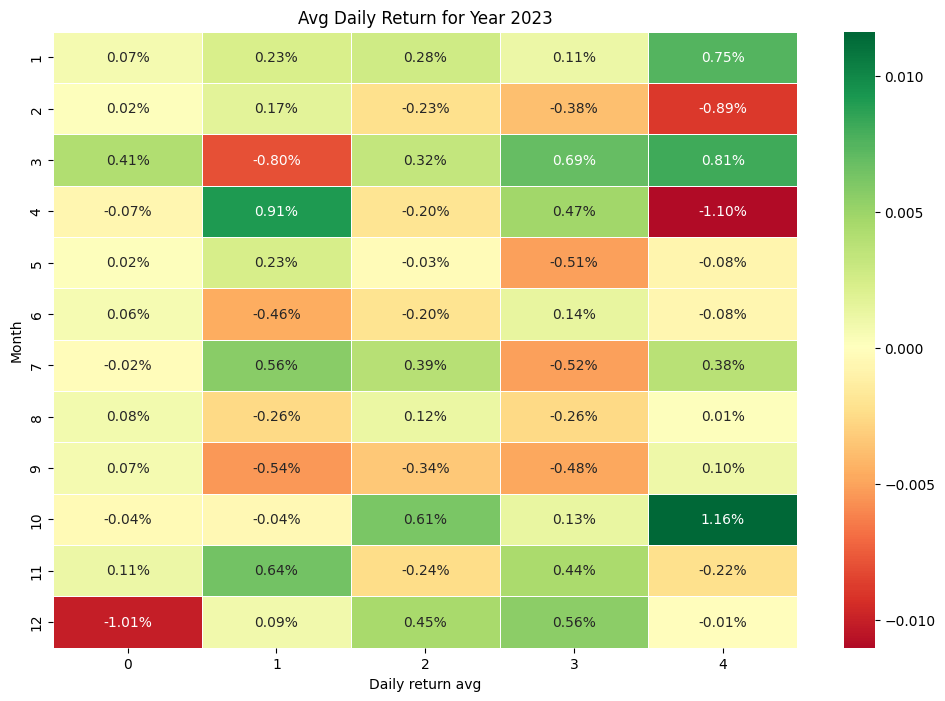

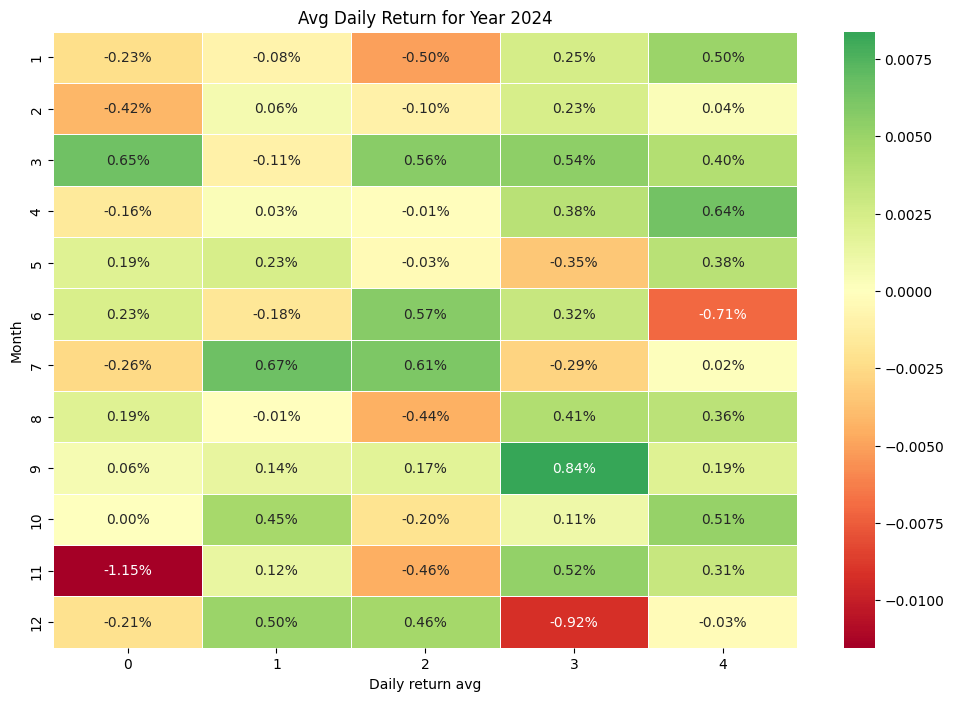

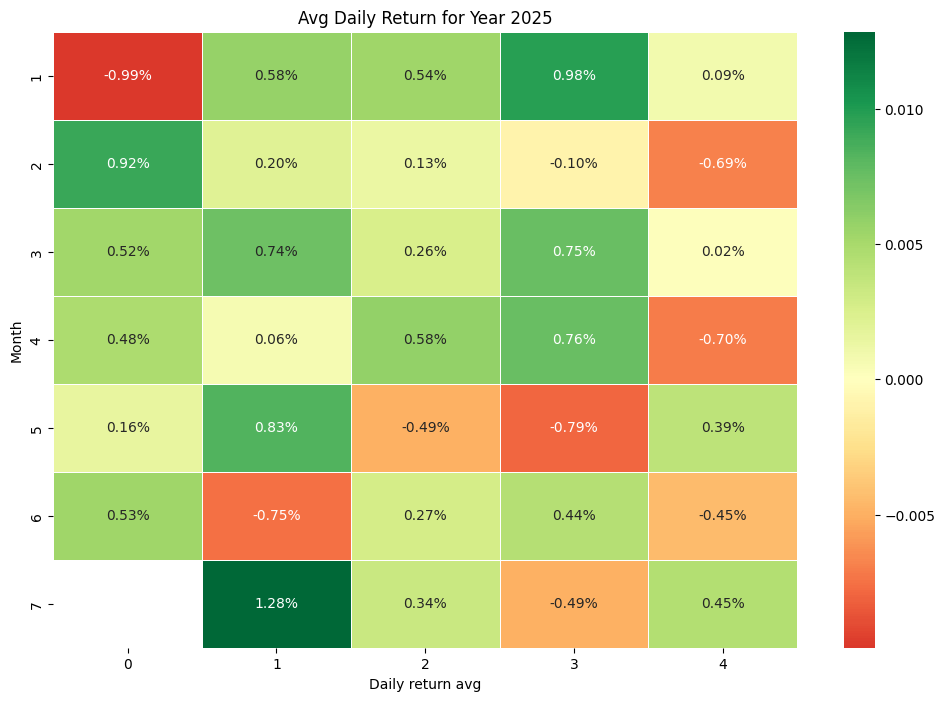

In [ ]:
# Create helper columns
ret['Year'] = ret.index.year
ret['Month'] = ret.index.month
ret['DayOfWeek'] = ret.index.dayofweek

# Group and pivot: average return for each (Month, DayOfWeek) across years
multi_pivot = ret.pivot_table(index=['Year','Month'], columns='DayOfWeek', values='Returns', aggfunc='mean')

# Plot heatmap
for year in sorted(ret["Year"].unique()):
  pivot=multi_pivot.loc[year]
  plt.figure(figsize=(12, 8))
  sns.heatmap(pivot, annot=True, fmt=".2%", cmap="RdYlGn", center=0, linewidths=0.5)
  plt.title(f"Avg Daily Return for Year {year}")
  plt.ylabel("Month")
  plt.xlabel("Daily return avg")
  # pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
  plt.show()


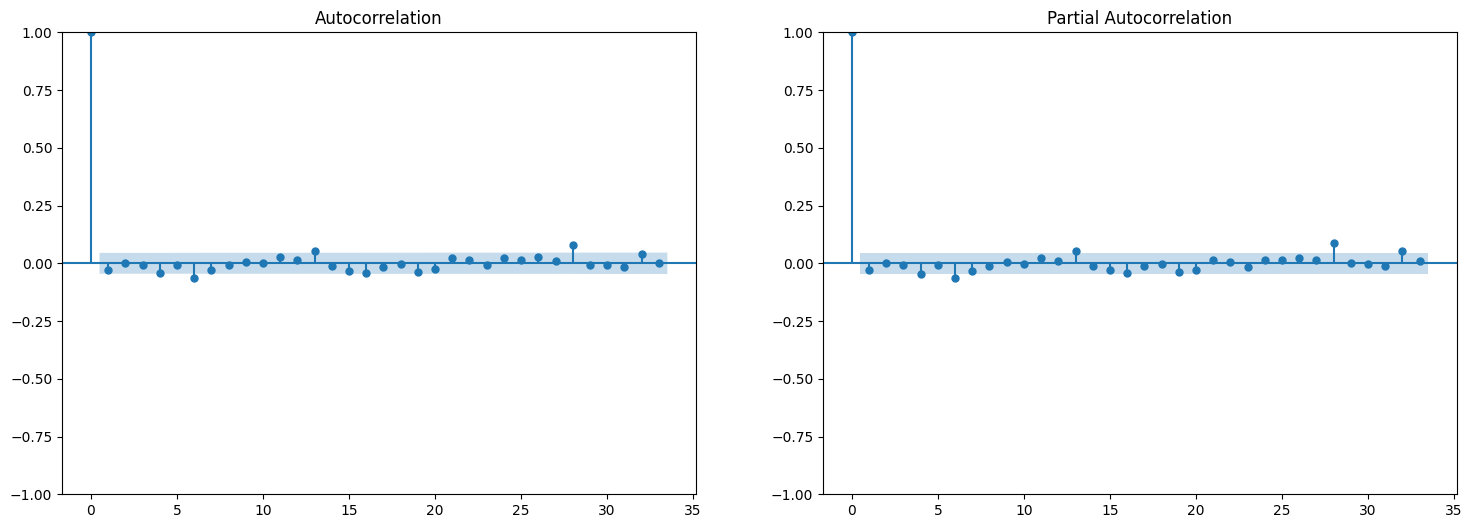

<Figure size 640x480 with 0 Axes>

In [ ]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(18,6))
plot_acf(ret["Returns"],ax=ax1)
plot_pacf(ret["Returns"],ax=ax2)
plt.show()
plt.tight_layout()

In [ ]:
# check comments for clarity
N=len(ret["Returns"])
fft_val=np.fft.fft(ret["Returns"])  ## returns array of fourier coefficients(acts like weigtage of each frequency to form our time series data)
fft_freq=np.fft.fftfreq(N)  ## create an array of frequency where f[i]=i/N when 0<=i<=N/2 and f[i]= -(N-i)/N for N/2<i<=N
mask=(fft_freq>0)
freq=fft_freq[mask]
powers=np.abs(fft_val)[mask]

# take only those frequencies whcih have highest weightage (Top 5)
top_weightage=np.argsort(powers)[-5:][::-1]  ##[::-1] reverses the order from low-->high to high-->low

for i in top_weightage:
  print(f"Period: {1/freq[i]:.3f} days (power/strength= {powers[i]:.2f})")

Period: 9.276 days (power/strength= 1.06)
Period: 10.461 days (power/strength= 1.03)
Period: 2.348 days (power/strength= 1.02)
Period: 4.473 days (power/strength= 1.01)
Period: 2.042 days (power/strength= 0.96)


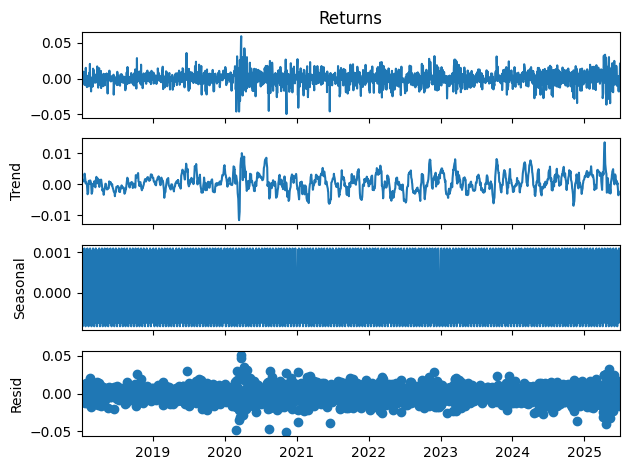

In [ ]:
decomp=seasonal_decompose(ret["Returns"],model="additive",period=10)

decomp.plot();

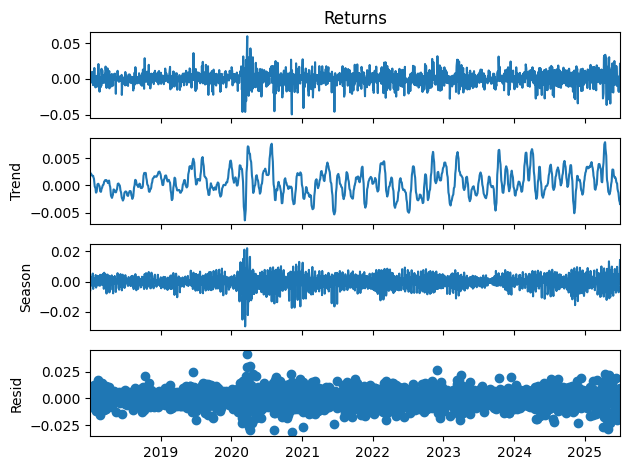

In [ ]:
decomp2=STL(ret['Returns'],period=10)
res=decomp2.fit()
res.plot();

## Weekly Data

In [ ]:
Weekly_data=yf.download(tickers,period='7y',interval="1wk",multi_level_index=False)
Weekly_data

/tmp/ipython-input-58-1971380966.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Weekly_data=yf.download(tickers,period='7y',interval="1wk",multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2018-07-02,1254.300049,1255.500000,1254.300049,1255.500000,7
2018-07-09,1239.599976,1262.300049,1239.599976,1258.199951,141
2018-07-16,1229.500000,1243.800049,1211.699951,1242.699951,102
2018-07-23,1222.599976,1231.400024,1222.000000,1222.000000,254430
2018-07-30,1214.199951,1228.099976,1205.099976,1222.500000,67182
...,...,...,...,...,...
2025-06-02,3322.699951,3400.000000,3296.899902,3296.899902,8405
2025-06-09,3431.199951,3444.000000,3290.000000,3315.600098,6375
2025-06-16,3368.100098,3442.000000,3341.000000,3442.000000,2666


In [ ]:
weekly_ret=pd.DataFrame()
weekly_ret["Returns"]=Weekly_data["Close"].pct_change()
weekly_ret["Volume"]=Weekly_data["Volume"]
weekly_ret.dropna(inplace=True)
weekly_ret.index=pd.to_datetime(weekly_ret.index)

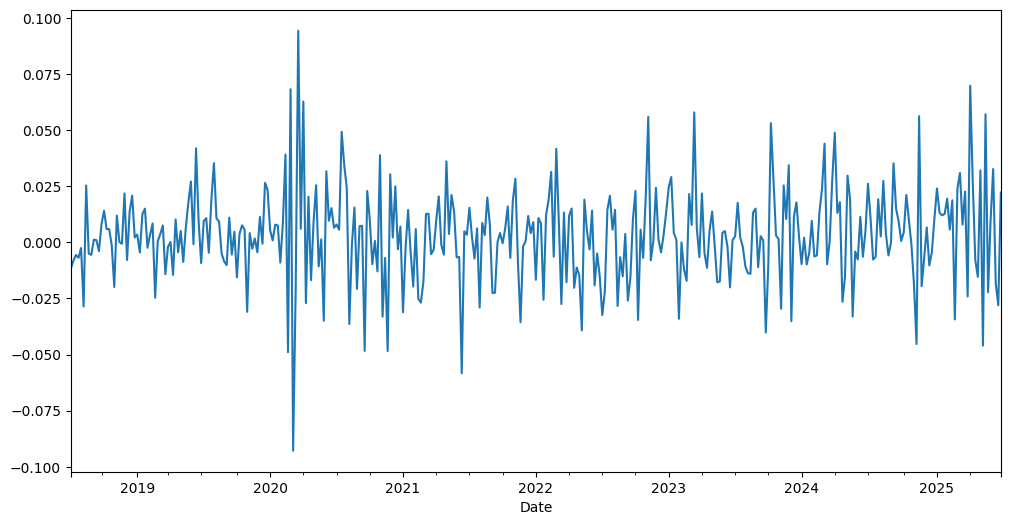

In [ ]:
weekly_ret['Returns'].plot(figsize=(12,6));

In [ ]:
_,pval,_,_,_,_=adfuller(weekly_ret["Returns"])
if pval>0.05:
  print("Not Stationary")
else:
  print("Stationary")

Stationary


In [ ]:
N=len(weekly_ret)
fft=np.fft.fft(weekly_ret['Returns'])
fft_freq=np.fft.fftfreq(N)
mask=(fft_freq>0)
freq=fft_freq[mask]
power=np.abs(fft)[mask]
periods=1/freq

top_wgt=power.argsort()[-5:][::-1]
for i in top_wgt:
  print(f"Period: {periods[i]:.3f} weeks (power/strength= {power[i]:.2f})")

Period: 2.433 weeks (power/strength= 0.90)
Period: 5.984 weeks (power/strength= 0.83)
Period: 5.530 weeks (power/strength= 0.78)
Period: 3.042 weeks (power/strength= 0.76)
Period: 2.744 weeks (power/strength= 0.71)


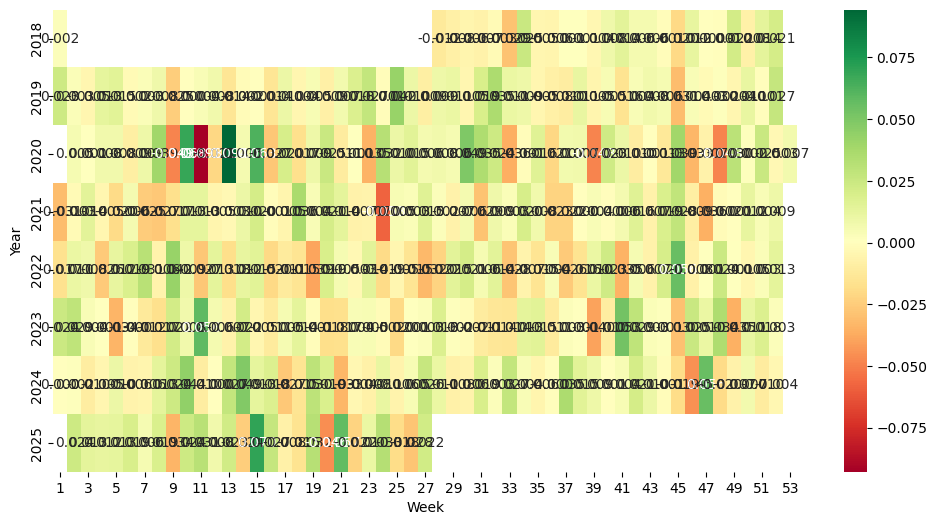

In [ ]:
weekly_ret['Year']=weekly_ret.index.year
weekly_ret['Month']=weekly_ret.index.month
weekly_ret['Week']=weekly_ret.index.isocalendar().week

pivot=weekly_ret.pivot_table(index='Year',columns='Week',values='Returns')
plt.figure(figsize=(12,6))
sns.heatmap(pivot,annot=True,cmap='RdYlGn',fmt='0.3f')
plt.show()

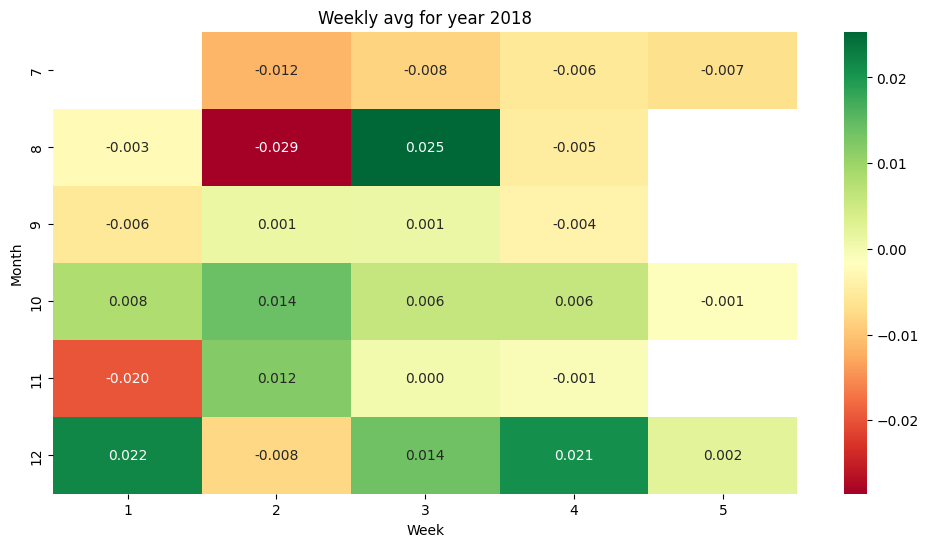

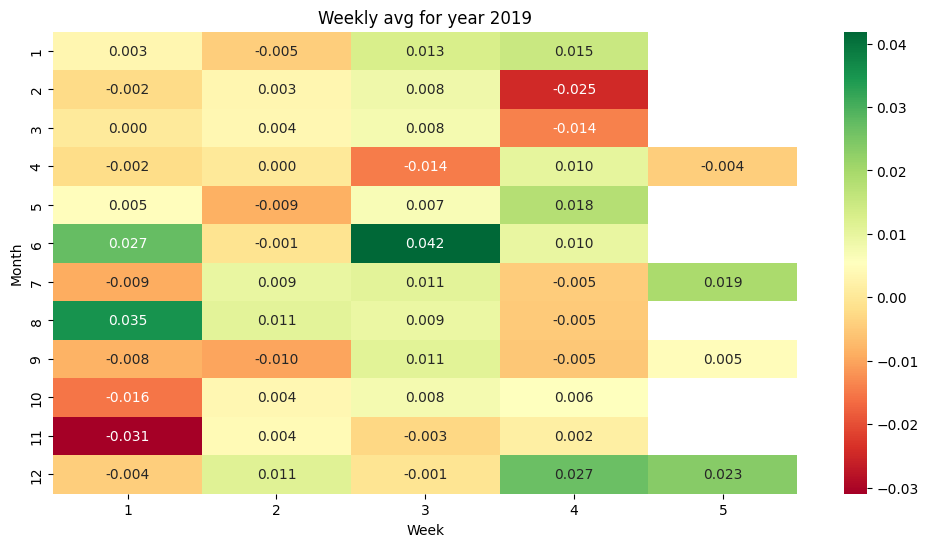

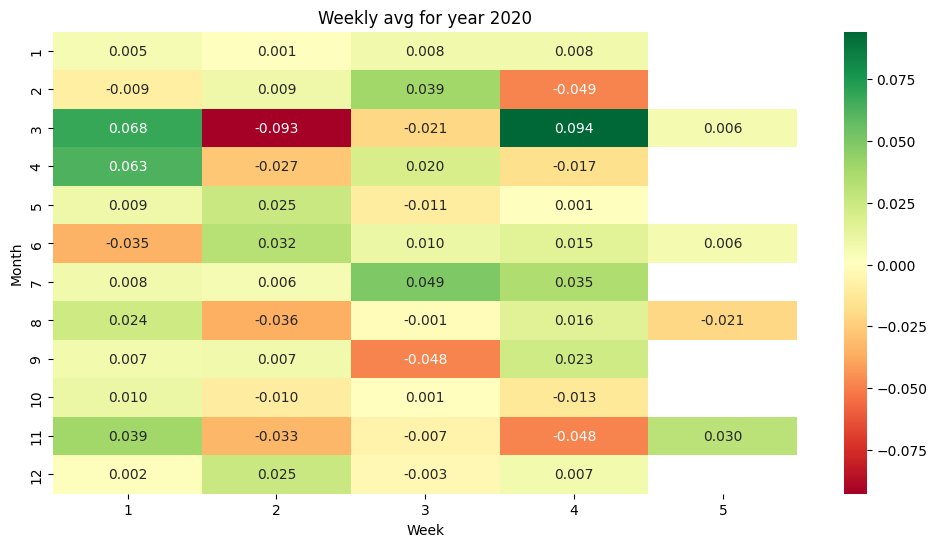

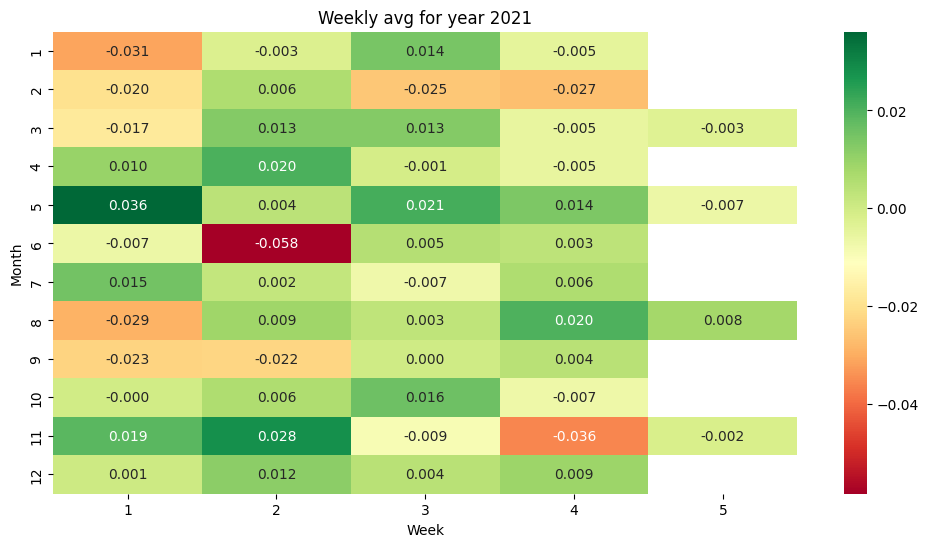

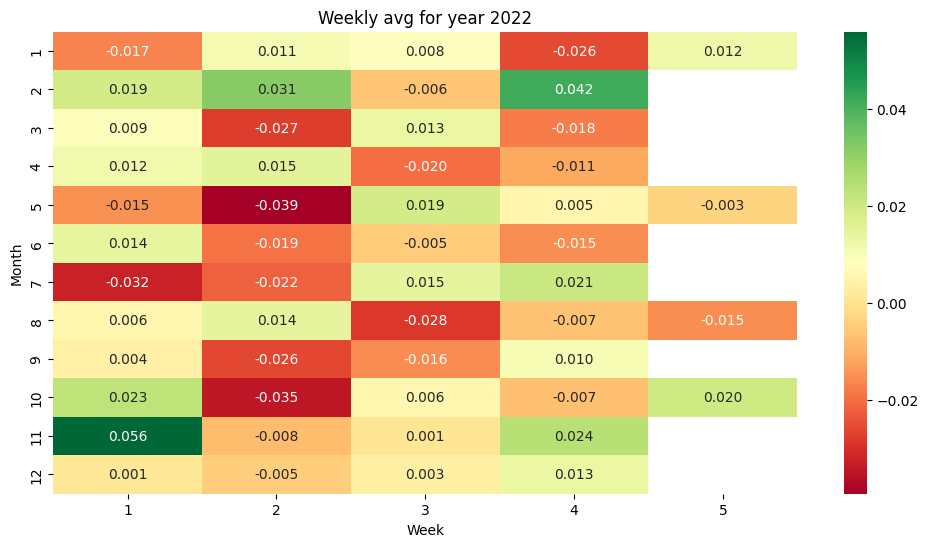

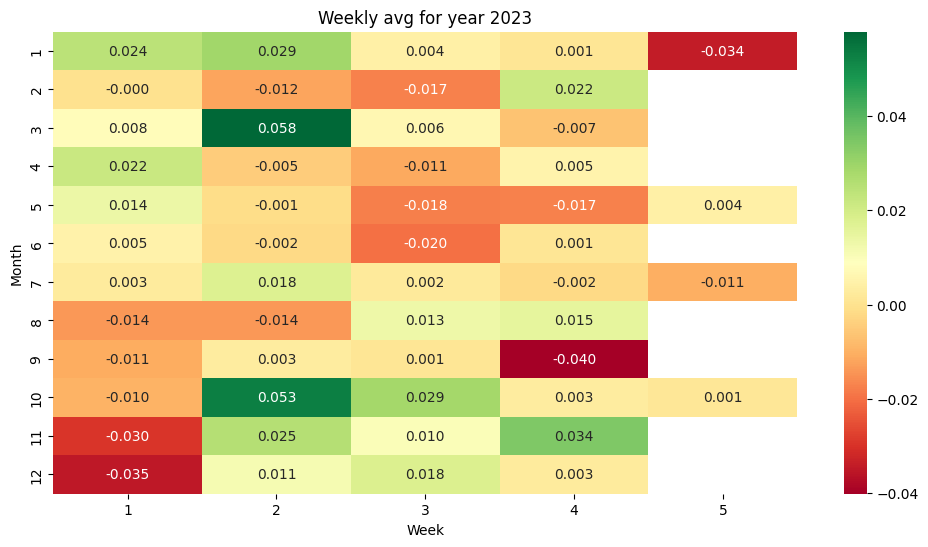

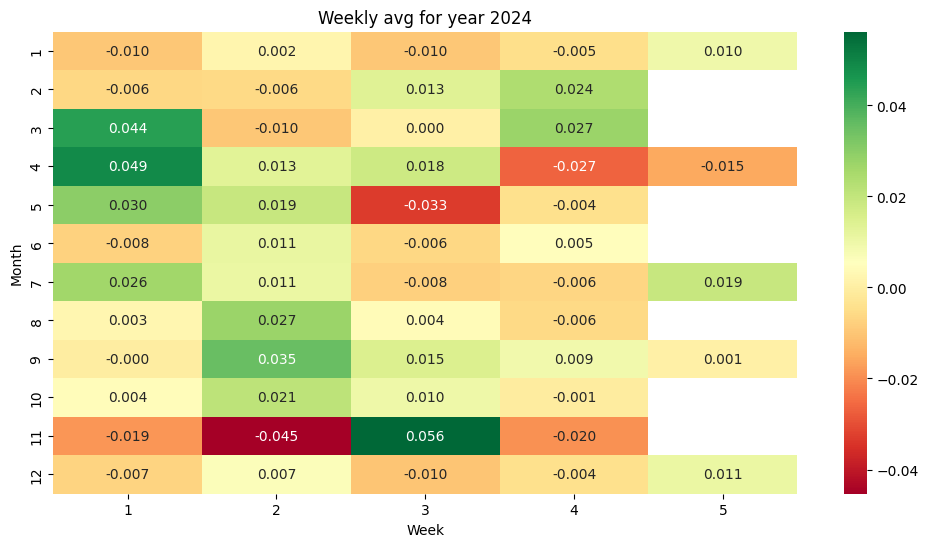

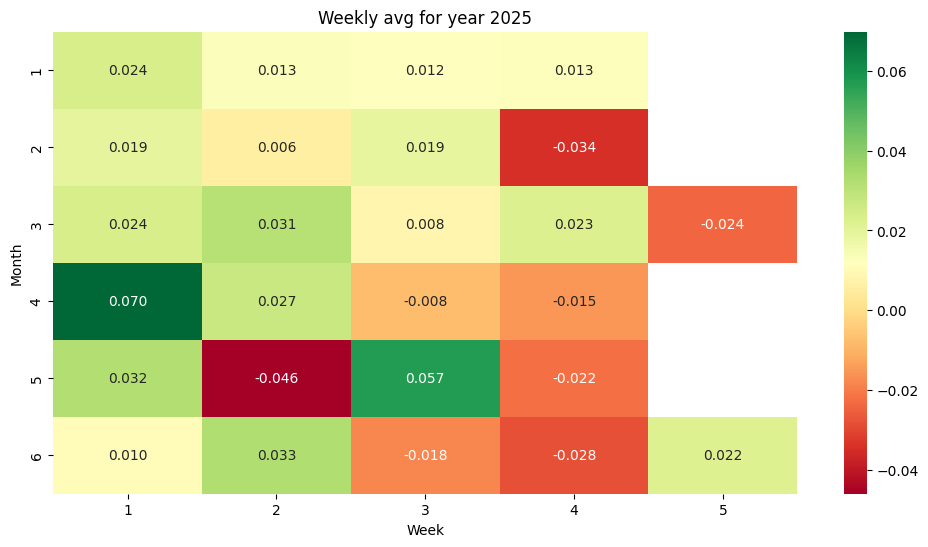

In [ ]:
weekly_ret['Year']=weekly_ret.index.year
weekly_ret['Month']=weekly_ret.index.month
# weekly_ret['Week']=weekly_ret.index.isocalendar().week
weekly_ret['Week'] = weekly_ret.index.to_series().apply(lambda d: (d.day - 1) // 7 + 1)


multi_pivot=weekly_ret.pivot_table(index=['Year','Month'],columns='Week',values='Returns')


for year in sorted(weekly_ret['Year'].unique()):
  pivot=multi_pivot.loc[year]
  plt.figure(figsize=(12,6))
  sns.heatmap(pivot,annot=True,cmap='RdYlGn',fmt='0.3f')
  plt.title(f'Weekly avg for year {year}')
  plt.show()

## Monthly Data

In [ ]:
monthly_price=yf.download(tickers,start='2018-01-01',end='2025-07-06',interval="1mo",multi_level_index=False)

/tmp/ipython-input-4-2057557028.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  monthly_price=yf.download(tickers,start='2018-01-01',end='2025-07-06',interval="1mo",multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


In [ ]:
monthly_price

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,1339.000000,1362.400024,1302.300049,1302.300049,338322
2018-02-01,1315.500000,1361.400024,1307.000000,1343.800049,10243
2018-03-01,1322.800049,1354.400024,1301.800049,1310.400024,356297
2018-05-01,1300.099976,1320.800049,1285.199951,1313.199951,441893
2018-06-01,1251.300049,1307.699951,1244.800049,1298.599976,5166
...,...,...,...,...,...
2025-02-01,2836.800049,2957.899902,2780.899902,2818.199951,46632
2025-03-01,3122.800049,3132.500000,2863.399902,2872.699951,168341
2025-04-01,3305.000000,3485.600098,2949.699951,3129.699951,38612


In [ ]:
monthly_ret=pd.DataFrame()
monthly_ret["Returns"]=monthly_price["Close"].pct_change()
monthly_ret["Volume"]=monthly_price["Volume"]
monthly_ret.dropna(inplace=True)
monthly_ret.index=pd.to_datetime(monthly_ret.index)
monthly_ret

,Returns,Volume
Date,,
2018-02-01,-0.017550,10243
2018-03-01,0.005549,356297
2018-05-01,-0.017161,441893
2018-06-01,-0.037536,5166
2018-08-01,-0.040758,5996
...,...,...
2025-02-01,0.008640,46632
2025-03-01,0.100818,168341
2025-04-01,0.058345,38612


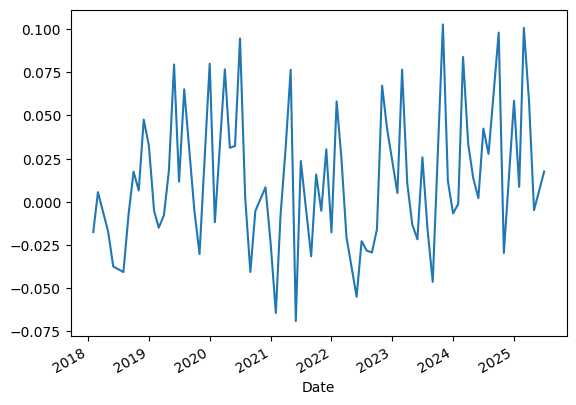

In [ ]:
monthly_ret["Returns"].plot();

In [ ]:
_,p,_,_,_,_=adfuller(monthly_ret["Returns"])
if p>0.05:
  print("Not Stationary")
else:
  print("Stationary")

Stationary


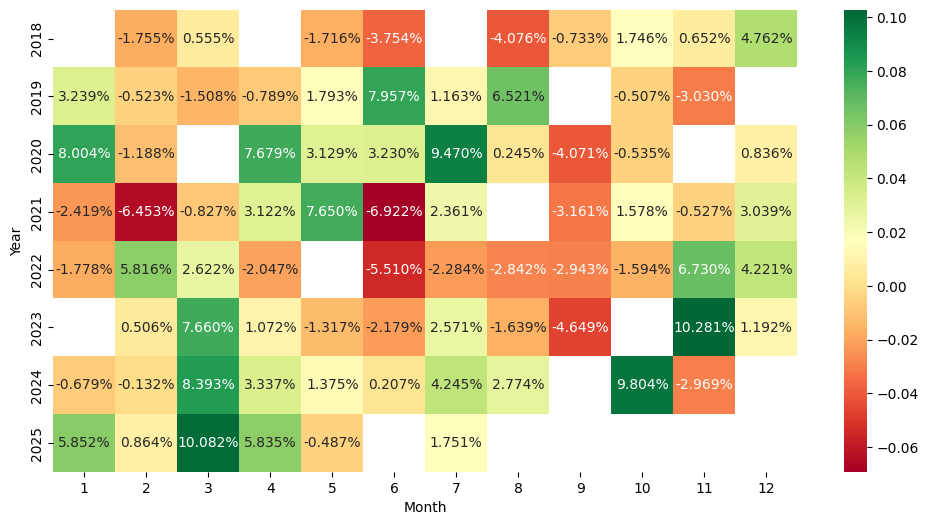

In [ ]:
monthly_ret["Year"]=monthly_ret.index.year
monthly_ret["Month"]=monthly_ret.index.month
pivot=monthly_ret.pivot_table(index="Year",columns="Month",values="Returns",aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(pivot,annot=True,fmt=".3%",cmap='RdYlGn')
plt.show()

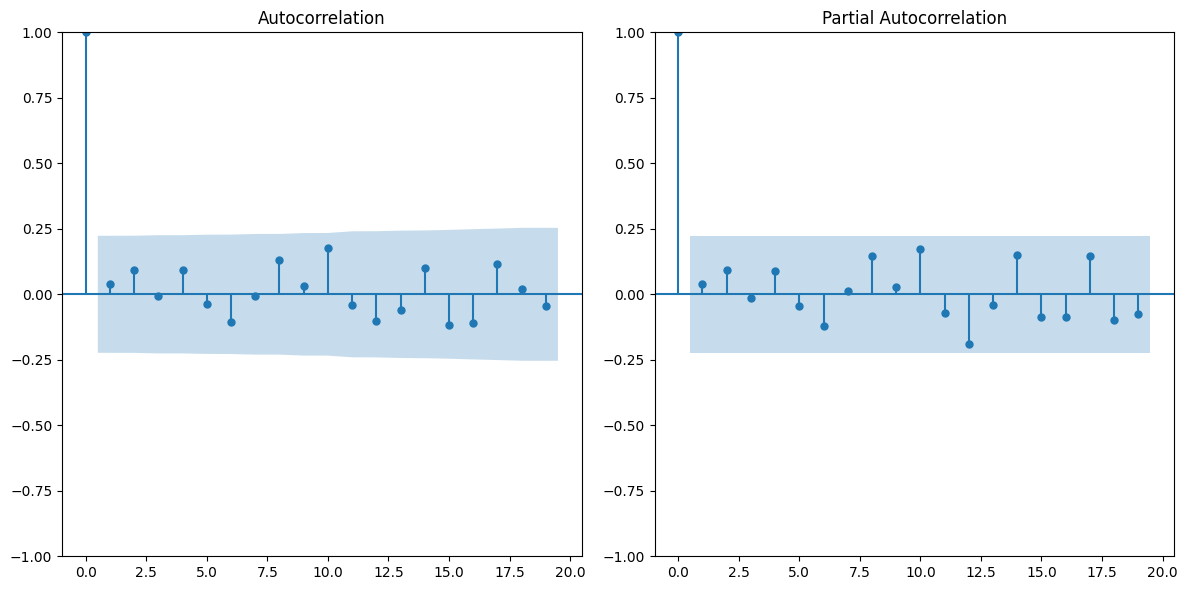

In [ ]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
plot_acf(monthly_ret["Returns"],ax=ax1)
plot_pacf(monthly_ret["Returns"],ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
fft_val=np.fft.fft(monthly_ret["Returns"])
freq=np.fft.fftfreq(len(monthly_ret["Returns"]))

mask=(freq>=0)
freqs=freq[mask]
powers=np.abs(fft_val)[mask]
periods=1/freqs

/tmp/ipython-input-44-3884500078.py:7: RuntimeWarning: divide by zero encountered in divide
  periods=1/freqs


In [ ]:

top_weight=powers.argsort()[-6:][::-1]

for i in top_weight:
  print(f"Period: {periods[i]:.3f} months (power/strength= {powers[i]:.2f})")


Period: inf months (power/strength= 0.99)
Period: 4.529 months (power/strength= 0.66)
Period: 8.556 months (power/strength= 0.63)
Period: 2.026 months (power/strength= 0.53)
Period: 3.500 months (power/strength= 0.50)
Period: 25.667 months (power/strength= 0.49)


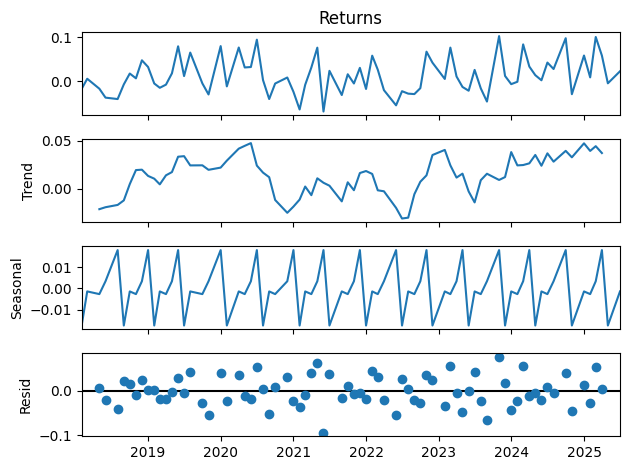

In [ ]:
decomp_monthly=seasonal_decompose(monthly_ret["Returns"],model="additive",period=5)
decomp_monthly.plot();

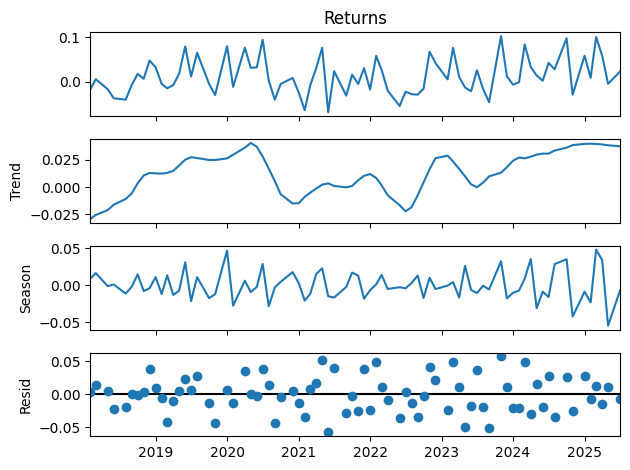

In [ ]:
monthly_decomp=STL(monthly_ret["Returns"],period=5)
res=monthly_decomp.fit()
res.plot();